In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
signal = ObjIter([Tree(fc.eightb.preselection_y.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(fc.eightb.preselection_y.QCD_B_List)])

bkg = qcd

In [4]:
t8btag = CollectionFilter('jet', filter=lambda t: ak.argsort(ak.argsort(-t.jet_btag, axis=-1), axis=-1)<8 )

signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)

In [5]:
varinfo.clear()

In [6]:
for y in eightb.ylist:
  (signal+bkg).apply(lambda t:build_collection(t,f'H\d{y}_b\d', f'{y}_jet', ptordered=True))

In [7]:
pair_index = combinations(4, [2,2])
def pair_y_higgs(t, y='Y1'):
  jets = get_collection(t, f'{y}_jet', False)

  def _higgs(jets):
    jp4 = [ build_p4(jets[:,i], use_regressed=True) for i in range(2) ]
    hp4 = jp4[0] + jp4[1]
    return ak.zip({ var:getattr(hp4,var) for var in ('pt','m','eta','phi') })
  higgs = ak_stack([ 
    ak_stack([_higgs(jets[:,comb[0]]), _higgs(jets[:,comb[1]])])
    for comb in pair_index 
  ])
  higgs = reorder_collection(higgs, ak.argsort(-higgs.pt, axis=-1))
  h1, h2 = higgs[:,:,0], higgs[:,:,1]
  t.extend( rename_collection(h1, f'{y}_h1'), rename_collection(h2, f'{y}_h2') )

(signal+bkg).apply(pair_y_higgs)
(signal+bkg).apply(lambda t:pair_y_higgs(t, y='Y2'))


[None, None]

100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


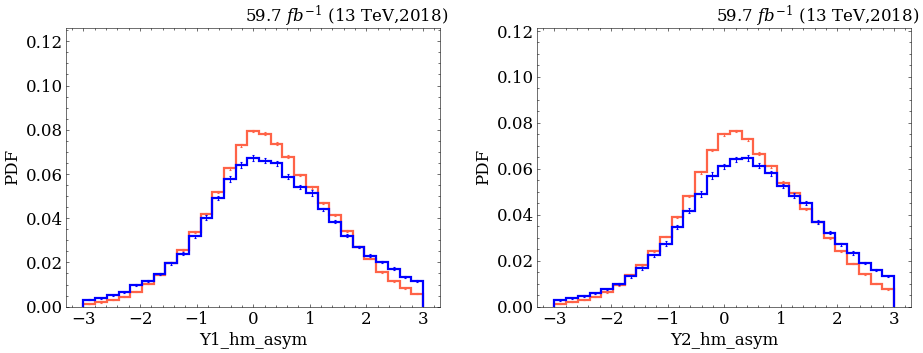

In [8]:
class hm_asym(ObjTransform):
  def init(self):
    self.xlabel = f'{self.y}_hm_asym'
    self.bins   = (-3,3,30)
  def __call__(self, t):
    h1 = t[f'{self.y}_h1_m']
    h2 = t[f'{self.y}_h2_m']
    asym = (h1-h2)/125
    t.extend(**{f'{self.y}_hm_asym':asym})
    return asym

study.quick(
  signal+bkg,
  varlist=[hm_asym(y='Y1'), hm_asym(y='Y2')],
  efficiency=True,
)



100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


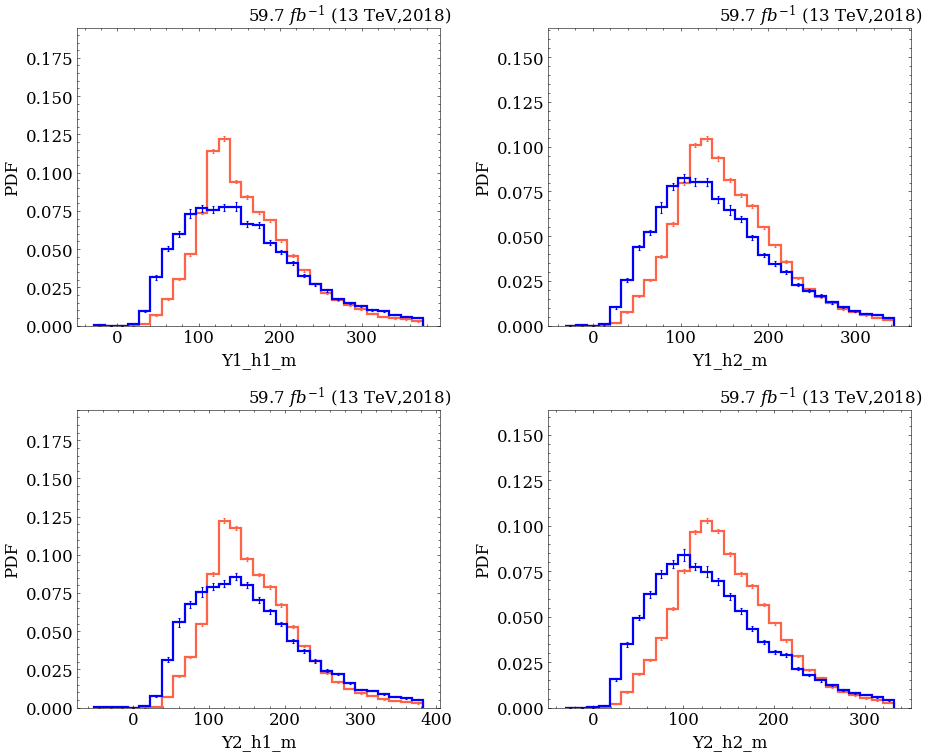

In [11]:
class asym_min(ObjTransform):
  def init(self):
    self.xlabel = f'{self.y}_{self.var}'
  def __call__(self, t):
    argmin = ak.argmin( np.abs(t[f'{self.y}_hm_asym']),axis=-1, keepdims=True)
    return t[f'{self.y}_{self.var}'][argmin]

study.quick(
  signal+bkg,
  varlist=[asym_min(y='Y1',var='h1_m'),asym_min(y='Y1',var='h2_m'),asym_min(y='Y2',var='h1_m'),asym_min(y='Y2',var='h2_m')],
  efficiency=True,
)

100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


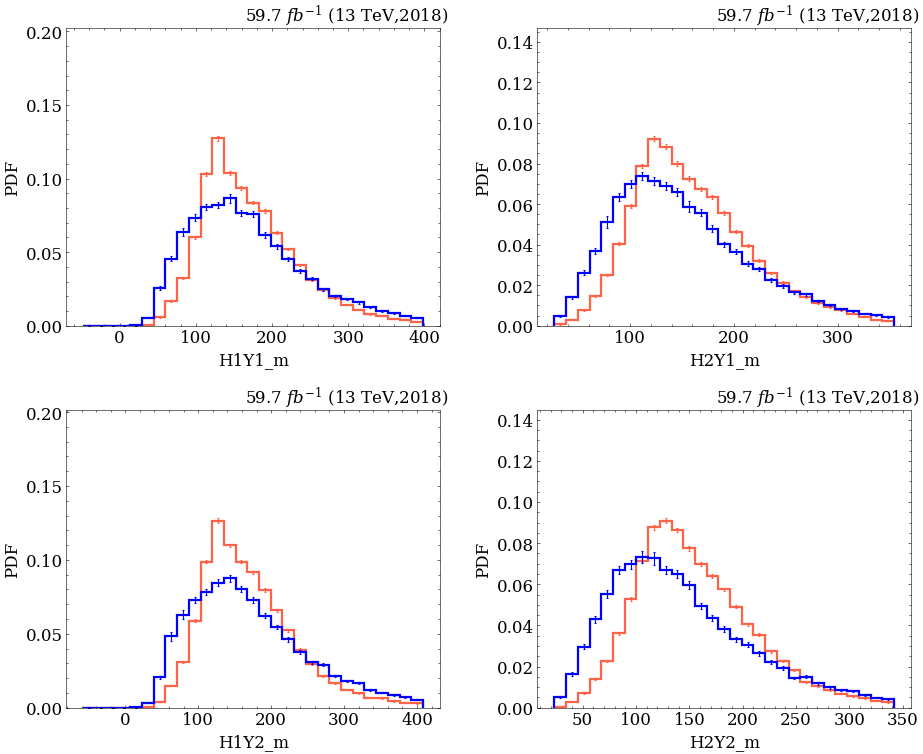

In [18]:
study.quick(
  signal+bkg,
  varlist=['H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
  efficiency=True,
  # contour=True,
)

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


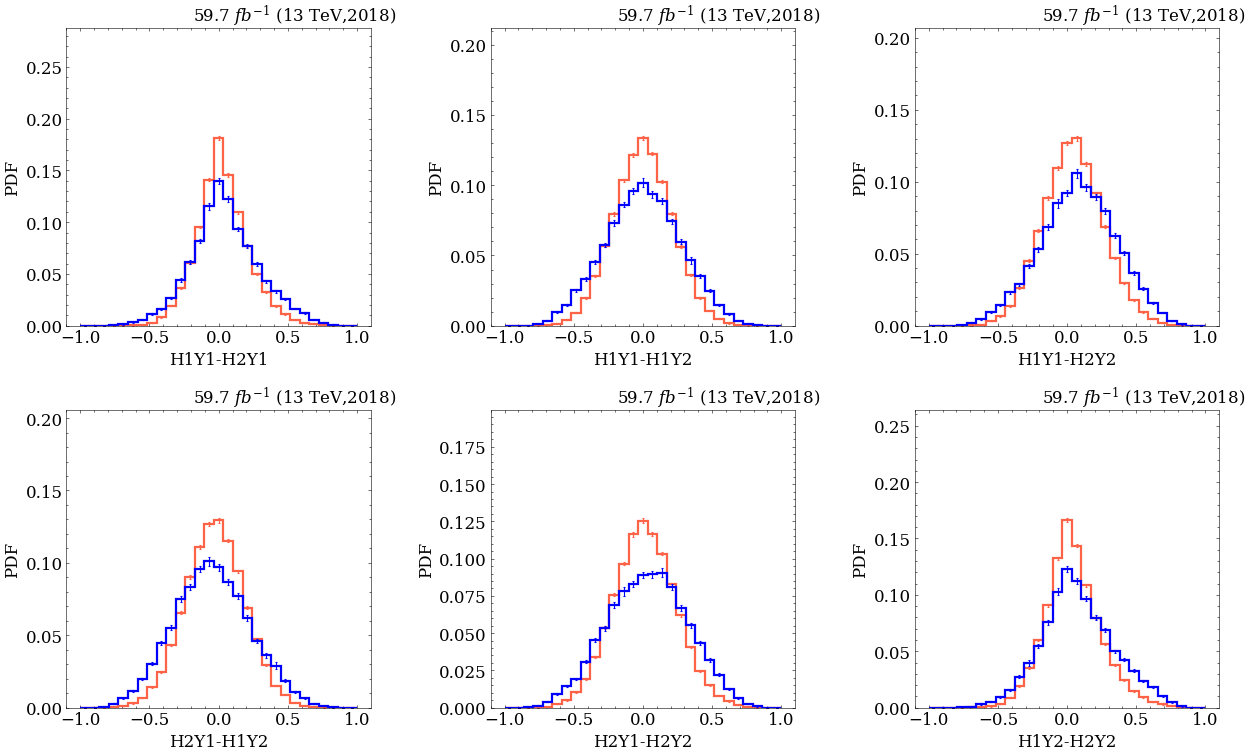

In [25]:
class hm_asym(ObjTransform):
  def init(self):
    self.xlabel = f'{self.h1}-{self.h2}'
    self.bins = (-1,1,30)
  def __call__(self, t):
    h1, h2 = t[f'{self.h1}_m'], t[f'{self.h2}_m'] 
    return (h1-h2)/(h1+h2)

study.quick(
  signal+bkg,
  varlist=[ hm_asym(h1=h1, h2=h2) for i, h1 in enumerate(eightb.higgslist) for h2 in eightb.higgslist[i+1:] ],
  efficiency=True,
  dim=(-1,3),
)

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


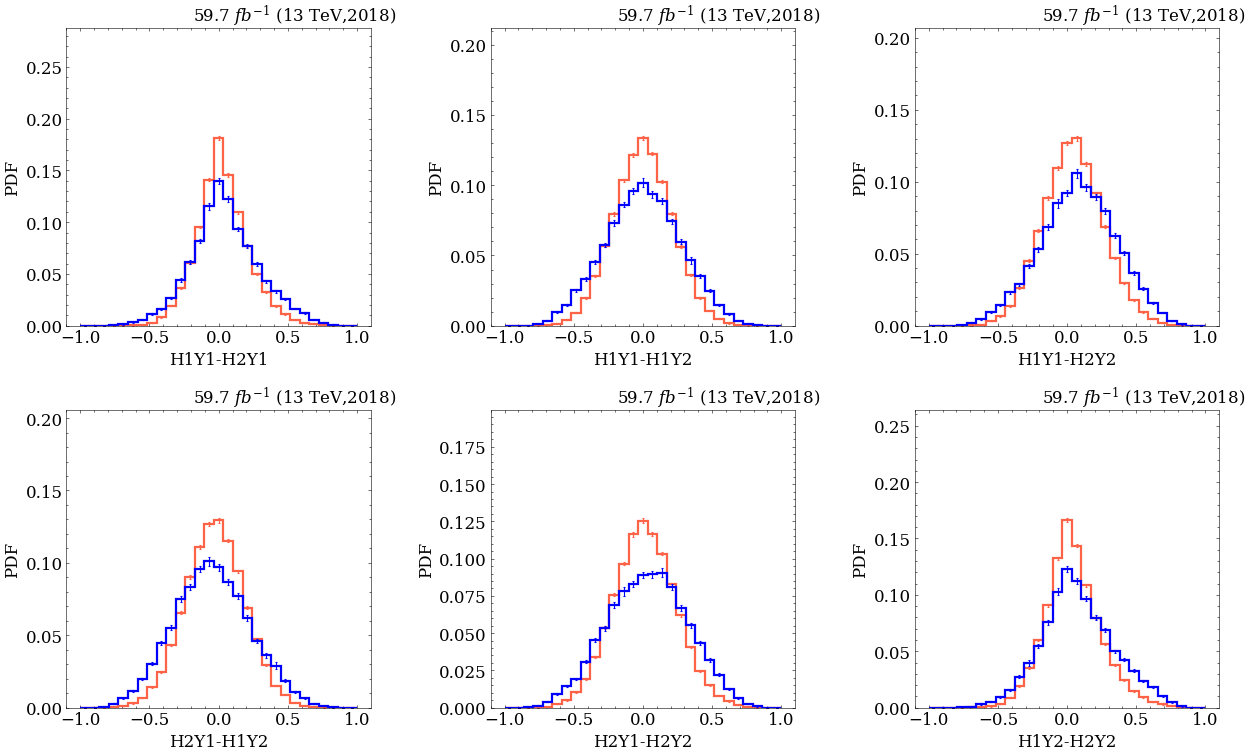

In [ ]:
class hm_asym(ObjTransform):
  def init(self):
    self.xlabel = f'{self.h1}-{self.h2}'
    self.bins = (-1,1,30)
  def __call__(self, t):
    h1, h2 = t[f'{self.h1}_m'], t[f'{self.h2}_m'] 
    return (h1-h2)/(h1+h2)

study.quick(
  signal+bkg,
  varlist=[ hm_asym(h1=h1, h2=h2) for i, h1 in enumerate(eightb.higgslist) for h2 in eightb.higgslist[i+1:] ],
  efficiency=True,
  dim=(-1,3),
)